In [1]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, auc
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

plt.style.use('seaborn-ticks')
%matplotlib inline

C:\Users\Pavilion\AppData\Local\Temp\ipykernel_14828\740701090.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


In [2]:
def plot_roc_curve(y_test, prob):
    # Compute ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, prob[:,1])
    
    # Find the optimal threshold
    optimal_idx = np.argmin(np.sqrt((1-tpr)**2 + fpr**2))
    optimal_threshold = thresholds[optimal_idx]
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label='Optimal Threshold')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

    return optimal_threshold

In [3]:
def plot_densities(data, names):
    # Set fig size
    plt.rcParams['figure.figsize'] = 15, 20

    # Init figure
    fig, axs = plt.subplots(len(names) - 1, 1)
    fig.suptitle('Features densities for different outcomes 0/1')
    plt.subplots_adjust(left=0.25, right=0.9, bottom=0.1, top=0.95, wspace=0.2, hspace=0.9)

    # Plot densities for outcomes
    for idx, column_name in enumerate(names[:-1]):
        ax = axs[idx]
        data[data['DEATH_EVENT'] == 0][column_name].plot(kind='density', ax=ax, 
                                                         color="green", legend=True,
                                                         label=f'{column_name} for DEATH_EVENT = 0')
        data[data['DEATH_EVENT'] == 1][column_name].plot(kind='density', ax=ax, 
                                                         color="red", legend=True,
                                                         label=f'{column_name} for DEATH_EVENT = 1')
        ax.set_xlabel(f'{column_name} values')
        ax.set_title(f'{column_name} density')
        ax.grid('on')

    plt.show()
    plt.rcParams['figure.figsize'] = 20, 10

In [4]:
def plot_roc(X_train, y_train, classifier, n_splits):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()

    for i, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
        classifier.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])  # Use iloc for DataFrame

        # Compute ROC values
        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], classifier.predict_proba(X_train.iloc[test_idx])[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

# Data description

Dataset - https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

age - Pacient's age

anaemia - Decrease of red blood cells or hemoglobin (boolean)

creatinine_phosphokinase - Level of the CPK enzyme in the blood (mcg/L)

diabetes - If the patient has diabetes (boolean)

ejection_fraction - Percentage of blood leaving the heart at each contraction (percentage)

high_blood_pressure - If the patient has hypertension (boolean)

platelets - Platelets in the blood (kiloplatelets/mL)

serum_creatinine - Level of serum creatinine in the blood (mg/dL)

serum_sodium - Level of serum sodium in the blood (mEq/L)

sex - Woman or man (1 stands for Male)

smoking - If the patient smokes or not (boolean)

time - Follow-up period (days)

DEATH_EVENT - If the patient deceased during the follow-up period (boolean)

In [5]:
#load the data

heart = pd.read_csv('D:\\UW\\2nd semester\\ML\\Project\\heart_failure_clinical_records_dataset.csv')

In [6]:
#dataset's size

heart.shape

(299, 13)

In [7]:
#types of variables

heart.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [8]:
#basic statistics

heart.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Oserving 75% percentile and max values we can mention that dataset potentially has outliers

In [9]:
#looking for NAs

heart.isnull().sum()
#sns.heatmap(heart.isnull(), yticklabels=False, cbar=False, cmap='viridis')

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Dataset has no missing values

<Axes: xlabel='DEATH_EVENT', ylabel='count'>

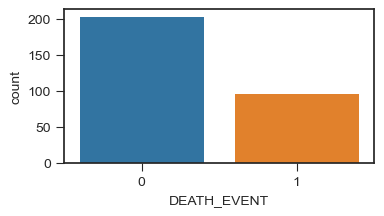

In [10]:
plt.figure(figsize=(4, 2))
sns.countplot(x='DEATH_EVENT', data=heart)

From the above graph we can observe that independent variable is unbalanced

In [11]:
#selecting numerical columns

numCols = ['age', 'creatinine_phosphokinase',
       'ejection_fraction',  'platelets',
       'serum_creatinine', 'serum_sodium', 'time']

In [12]:
#selecting categorical columns

levCols = [col for col in heart.columns if col not in numCols]
levCols.remove('DEATH_EVENT')
levCols

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

C:\Users\Pavilion\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


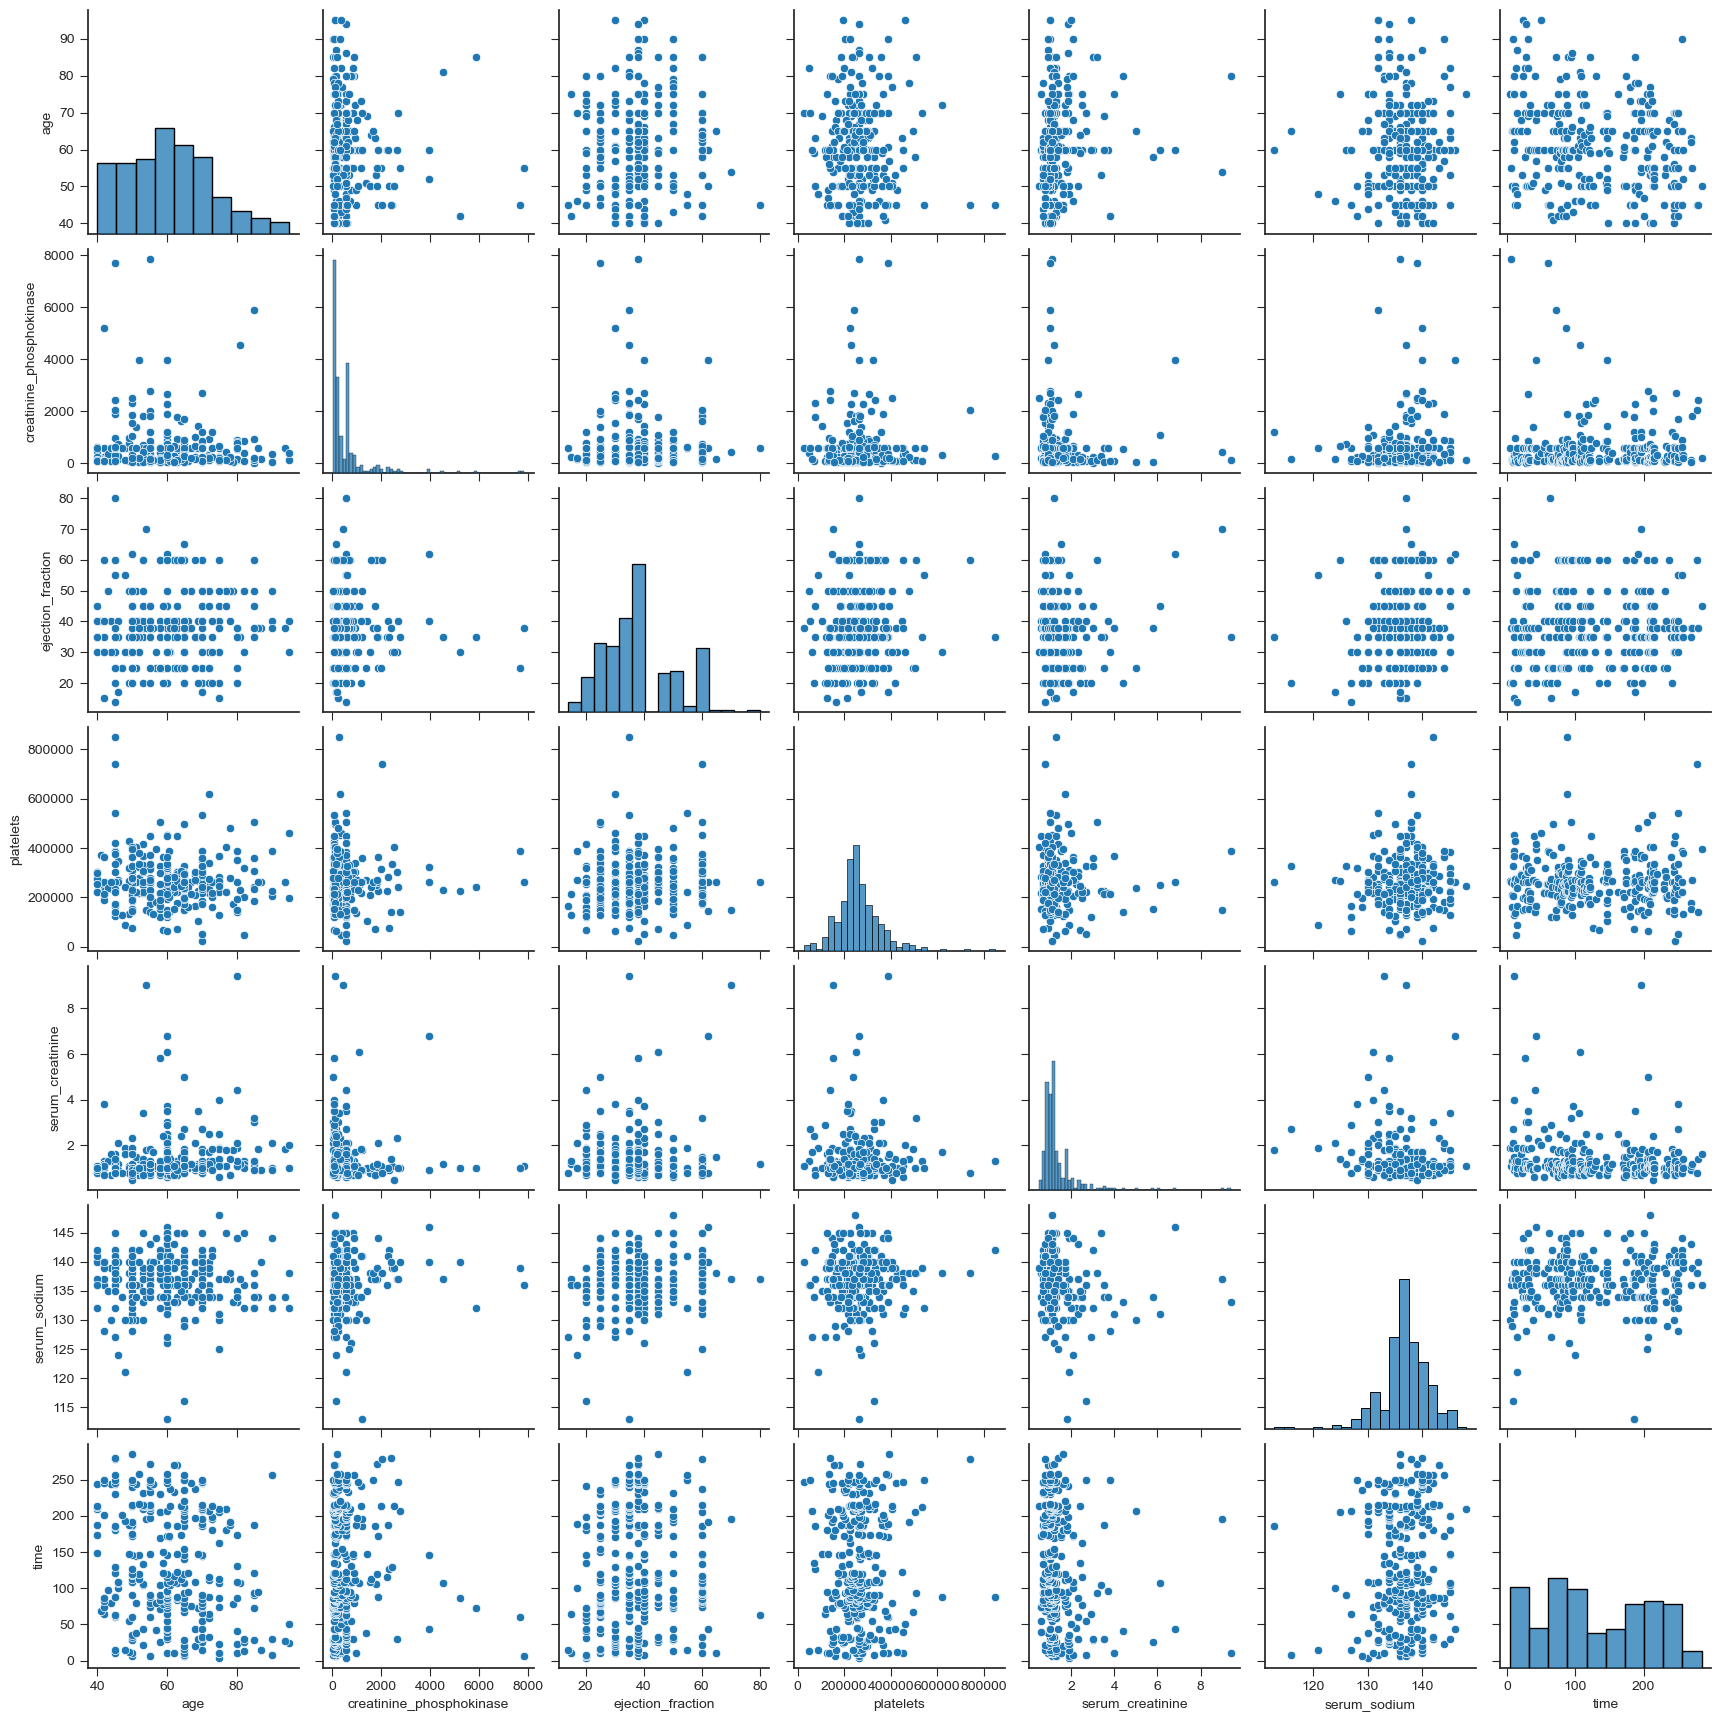

In [13]:
#visualization of contineous variables

sns.pairplot(heart[numCols])

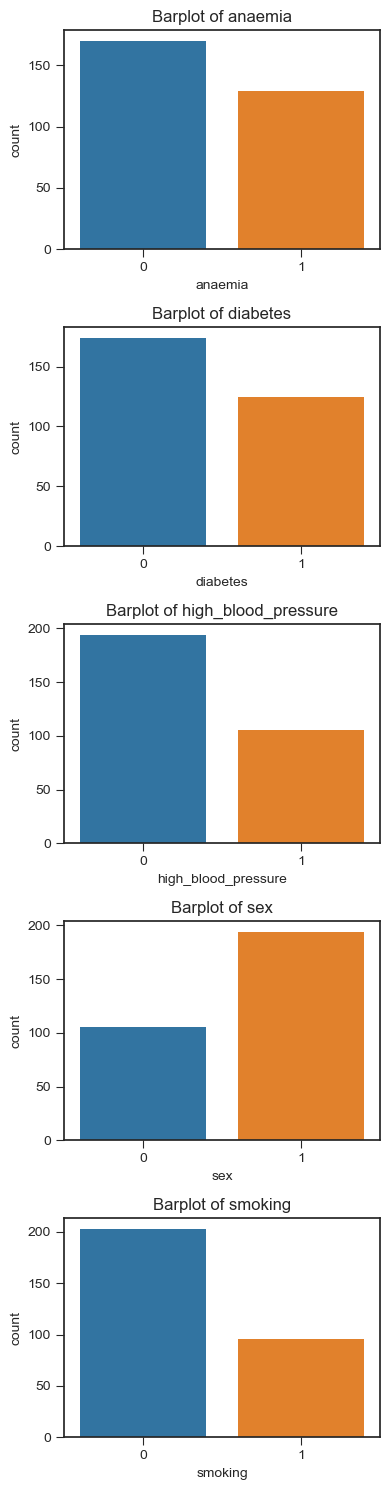

In [14]:
# Set up the grid
num_cols = len(heart[levCols].columns)
fig, axs = plt.subplots(num_cols, 1, figsize=(4, 3 * num_cols))

# Plot data
for i, col in enumerate(heart[levCols].columns):
    if col in levCols:
        sns.countplot(data=heart, x=col, ax=axs[i])
        axs[i].set_title(f'Barplot of {col}')

plt.tight_layout()
plt.show()

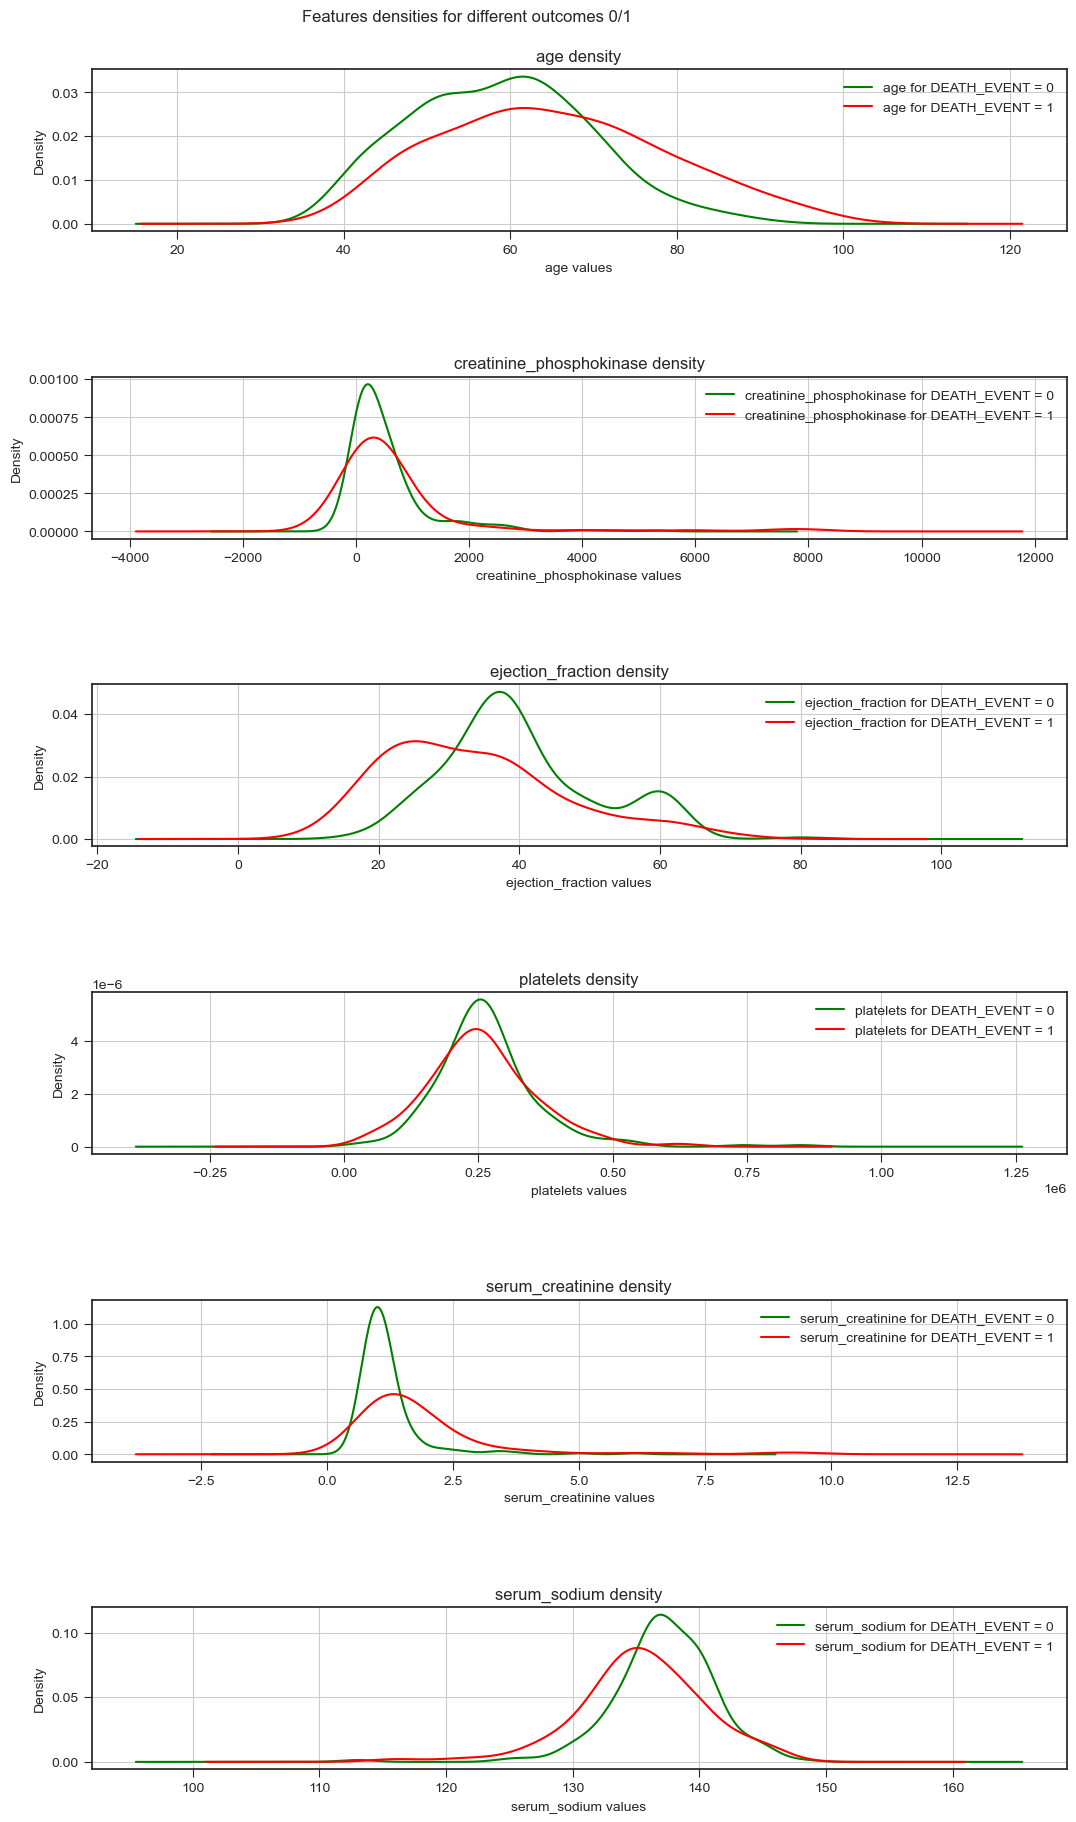

In [15]:
plot_densities(pd.concat([heart[numCols], heart['DEATH_EVENT']], axis=1), numCols)

Died pacients tend to be older, have less ejection fraction and shorter follow-up period

In [16]:
#crosstabs for categorical variables

for var in levCols:
    display((pd.crosstab(heart["DEATH_EVENT"], heart[var], margins=False, normalize = 'index')).round(3))

anaemia,0,1
DEATH_EVENT,,
0,0.591,0.409
1,0.521,0.479


diabetes,0,1
DEATH_EVENT,,
0,0.581,0.419
1,0.583,0.417


high_blood_pressure,0,1
DEATH_EVENT,,
0,0.675,0.325
1,0.594,0.406


sex,0,1
DEATH_EVENT,,
0,0.350,0.650
1,0.354,0.646


smoking,0,1
DEATH_EVENT,,
0,0.675,0.325
1,0.688,0.312


Smoking and sex variables seem to have no significant effect on death event. However, hipertension and anaemia differs depend on death event.

<Axes: >

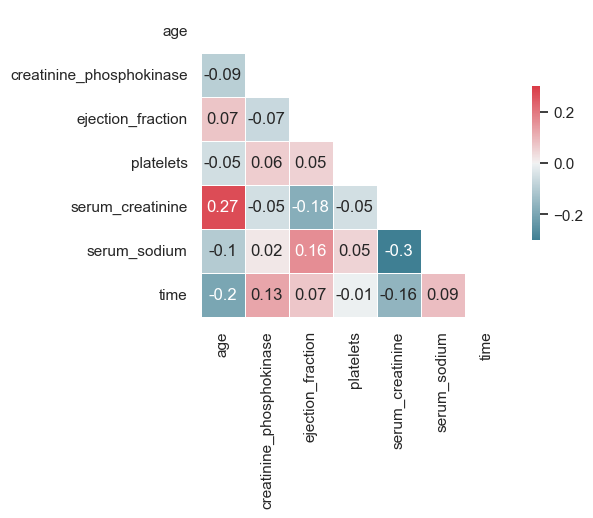

In [17]:
#correlation matrix for numerical variables with Spearman coefficients
sns.set(style="white")
plt.rcParams['figure.figsize'] = 6,4
corr = heart[numCols].corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0, 
    square=True, 
    annot=corr.round(2), 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

There are no highly-correlated numerical variables

<Axes: >

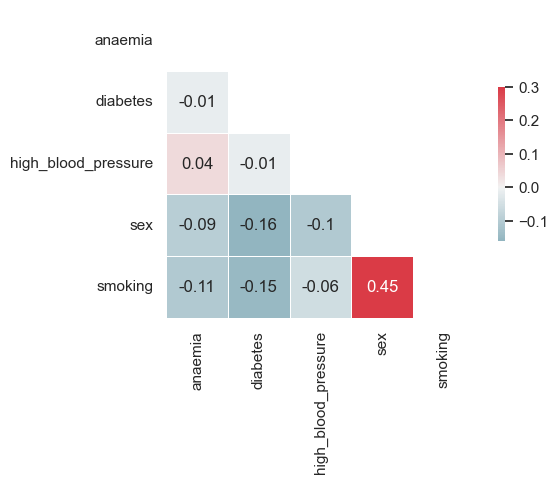

In [18]:
#correlation variable for categorical cariables with Phi coefficient

sns.set(style="white")

corr = heart[levCols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0, 
    square=True, 
    annot=corr.round(2), 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

In [19]:
pd.crosstab(heart["sex"], heart["smoking"], margins=False, normalize = 'index').round(3)

smoking,0,1
sex,,
0,0.962,0.038
1,0.526,0.474


Generally, correlation matricies shows that we don't have strong multicollinearity problem. Men are more likely to smoke, which results in highest correlation value (0.45), however the values is still to small to consider significant correlation.

# Feature selection and transformation

In [20]:
#TODO: make if loop instead of 2 for loops

In [21]:
#calculating Mutual info for every variable

minfos = []

for var in levCols:  # assuming levCols are discrete features
    coef = feature_selection.mutual_info_classif(heart[var].values.reshape(-1,1), heart['DEATH_EVENT'].values, discrete_features=True)[0]
    minfos.append((var, coef))

for var in numCols:  # assuming numCols are continuous features
    coef = feature_selection.mutual_info_classif(heart[var].values.reshape(-1,1), heart['DEATH_EVENT'].values, discrete_features=False)[0]
    minfos.append((var, coef))

# Sorting the list in descending order based on the coefficient
sorted_minfos = sorted(minfos, key=lambda x: x[1], reverse=True)

# To view the sorted result
for feature, coef in sorted_minfos:
    print(f"Variable: {feature}, Coefficient: {coef:.4f}")

Variable: time, Coefficient: 0.1895
Variable: serum_creatinine, Coefficient: 0.0883
Variable: age, Coefficient: 0.0741
Variable: ejection_fraction, Coefficient: 0.0516
Variable: serum_sodium, Coefficient: 0.0289
Variable: creatinine_phosphokinase, Coefficient: 0.0040
Variable: high_blood_pressure, Coefficient: 0.0031
Variable: anaemia, Coefficient: 0.0022
Variable: smoking, Coefficient: 0.0001
Variable: sex, Coefficient: 0.0000
Variable: diabetes, Coefficient: 0.0000
Variable: platelets, Coefficient: 0.0000


The most valuable variables are:
   * 'time'
   * 'creatinine_phosphokinase'
   * 'age'
   * 'ejection_fraction'
   * 'serum_sodium'
    
While 'sex', 'smoking' and 'diabetes', 'creatinine_phosphokinase' and 'platelets' doesn't seem to influence target variable a lot

In [22]:
#standartization for contineous variables

scaler = StandardScaler()
scaled_continuous_df = pd.DataFrame(scaler.fit_transform(heart[numCols]),columns=numCols)
result_df = pd.concat([heart[levCols], scaled_continuous_df, heart["DEATH_EVENT"]], axis=1)
result_df

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
0,0,0,1,1,0,1.192945,0.000166,-1.530560,1.681648e-02,0.490057,-1.504036,-1.629502,1
1,0,0,0,1,0,-0.491279,7.514640,-0.007077,7.535660e-09,-0.284552,-0.141976,-1.603691,1
2,0,0,0,1,1,0.350833,-0.449939,-1.530560,-1.038073e+00,-0.090900,-1.731046,-1.590785,1
3,1,0,0,1,0,-0.912335,-0.486071,-1.530560,-5.464741e-01,0.490057,0.085034,-1.590785,1
4,1,1,0,0,0,0.350833,-0.435486,-1.530560,6.517986e-01,1.264666,-4.682176,-1.577879,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0,1,1,1,1,0.098199,-0.537688,-0.007077,-1.109765e+00,-0.284552,1.447094,1.803451,0
295,0,0,0,0,0,-0.491279,1.278215,-0.007077,6.802472e-02,-0.187726,0.539054,1.816357,0
296,0,1,0,0,0,-1.333392,1.525979,1.854958,4.902082e+00,-0.575031,0.312044,1.906697,0
297,0,0,0,1,1,-1.333392,1.890398,-0.007077,-1.263389e+00,0.005926,0.766064,1.932509,0


Accuracy using features ['time', 'serum_creatinine', 'age', 'ejection_fraction', 'serum_sodium', 'creatinine_phosphokinase', 'high_blood_pressure', 'anaemia', 'smoking', 'sex', 'diabetes', 'platelets']: 0.8000
Accuracy using features ['time', 'serum_creatinine', 'age', 'ejection_fraction', 'serum_sodium', 'creatinine_phosphokinase', 'high_blood_pressure', 'anaemia', 'smoking', 'sex', 'diabetes']: 0.8000
Accuracy using features ['time', 'serum_creatinine', 'age', 'ejection_fraction', 'serum_sodium', 'creatinine_phosphokinase', 'high_blood_pressure', 'anaemia', 'smoking', 'sex']: 0.8167
Accuracy using features ['time', 'serum_creatinine', 'age', 'ejection_fraction', 'serum_sodium', 'creatinine_phosphokinase', 'high_blood_pressure', 'anaemia', 'smoking']: 0.8000
Accuracy using features ['time', 'serum_creatinine', 'age', 'ejection_fraction', 'serum_sodium', 'creatinine_phosphokinase', 'high_blood_pressure', 'anaemia']: 0.8000
Accuracy using features ['time', 'serum_creatinine', 'age', 'ej

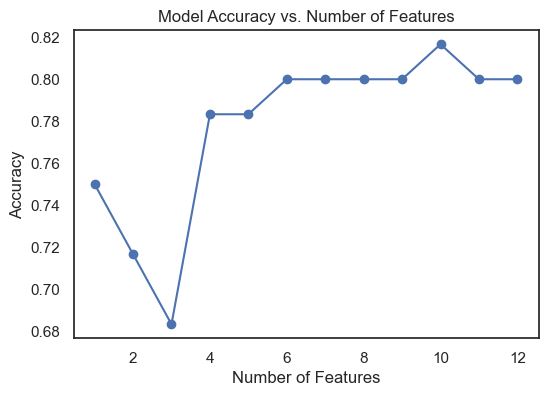

In [23]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(heart.drop('DEATH_EVENT', axis=1), 
                                                    heart['DEATH_EVENT'], test_size=0.2, random_state=42)

# Use all features initially
current_features = [feature for feature, _ in sorted_minfos]

# List to store accuracies
accuracies = []

# Initialize a Logistic Regression model
model = LogisticRegression(max_iter=1000)

for _ in range(len(current_features)):
    # Train the model on current features
    model.fit(X_train[current_features], y_train)
    
    # Predict and compute accuracy
    y_pred = model.predict(X_test[current_features])
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append to accuracies list
    accuracies.append(accuracy)
    
    # Print results
    print(f"Accuracy using features {current_features}: {accuracy:.4f}")
    
    # Remove the least significant feature for the next iteration
    current_features.pop()

# Optionally, you can plot the accuracies to visualize the trend
import matplotlib.pyplot as plt

plt.plot(range(len(sorted_minfos), 0, -1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Number of Features')
plt.show()

We don't see any increasement of quality with variables ellimination. So we will use all the dataset

In [24]:
#determine the final data for analysis

data = heart.drop('DEATH_EVENT', axis=1)
target = heart['DEATH_EVENT']

In [25]:
#define split parameters

X_train, X_test, y_train, y_test = train_test_split(data
                                                    , target
                                                    , test_size = 0.2
                                                    , random_state=42
                                                    , shuffle = True
                                                    ,stratify=target)

In [26]:
X_train

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
115,58.0,1,400,0,40,0,164000.0,1.0,139,0,0,91
23,53.0,0,63,1,60,0,368000.0,0.8,135,1,0,22
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4
247,64.0,0,143,0,25,0,246000.0,2.4,135,1,0,214
194,45.0,0,582,0,20,1,126000.0,1.6,135,1,0,180
...,...,...,...,...,...,...,...,...,...,...,...,...
229,72.0,0,211,0,25,0,274000.0,1.2,134,0,0,207
131,60.0,1,1082,1,45,0,250000.0,6.1,131,1,0,107
177,49.0,1,69,0,50,0,132000.0,1.0,140,0,0,147
112,50.0,0,369,1,25,0,252000.0,1.6,136,1,0,90


In [27]:
#standartization for contineous variables

scaler = StandardScaler()
X_train_num_std = scaler.fit_transform(X_train[numCols])
X_test_num_std = scaler.transform(X_test[numCols])

In [28]:
#merging scaled numerical columns with categorical 

X_train_std = pd.concat([pd.DataFrame(X_train_num_std, columns = numCols, index=X_train.index),X_train[levCols]], axis=1)
X_test_std = pd.concat([pd.DataFrame(X_test_num_std, columns = numCols, index=X_test.index),X_test[levCols]], axis=1)

# Logistic regression

As a basic model we will use Logistic regression so we can test if all the advanced methods will be significantly better.

In [29]:
#define and train the model

model = LogisticRegression()
model.fit(X_train_std, y_train)

LogisticRegression()

In [30]:
#check the accuracy of training

pred_train = model.predict(X_train_std)
accuracy_score(pred_train, y_train)

0.8577405857740585

In [31]:
#make predictions for test dataset 

pred = model.predict(X_test_std)
prob = model.predict_proba(X_test_std)

In [32]:
pd.crosstab(pred, y_test, colnames=['Prediction'])

Prediction,0,1
row_0,,
0,38,8
1,3,11


In [33]:
#quality evaluating

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.79      0.58      0.67        19

    accuracy                           0.82        60
   macro avg       0.81      0.75      0.77        60
weighted avg       0.81      0.82      0.81        60



During this analysis we will focus on minimazing False Negative rate - not to missclassify potential patient's death. Therefore, we will pay more attention to recall parameter. In this case - recall is quite low: we were able to catch 56% of death events

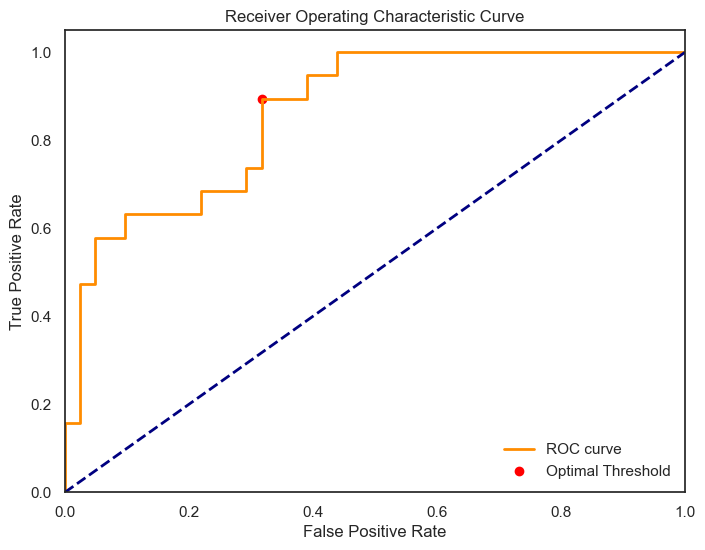

AUC score: 0.86
Optimal threshold: 0.14


In [34]:
# Plotting the ROC curve
optimal_thresh = plot_roc_curve(y_test, prob)

# Computing and displaying the AUC score
auc_score = roc_auc_score(y_test, prob[:,1])
print(f'AUC score: {auc_score:.2f}')
print(f'Optimal threshold: {optimal_thresh:.2f}')

As a measuer for comparison models between themselves we will use AUC. The score for Logistic Regression is 0.83 (the range is from 0 to 1 - the higher the better). Optimal probability threshold for Logistic regression based on ROC curve is 0.28.

# Cross validation

In [35]:
#import libraries

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 123)
model = LogisticRegression(max_iter=1000)

As we found out that target variable is unbalanced we will use stratified KFold cross validation.
Out dataset is quite small so 5 folds will be enough.

In [36]:
#checking stratification

fold_no = 1
for train_index, test_index in skf.split(data, target):
    train = heart.loc[train_index,:]
    test = heart.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:',
          sum(test['DEATH_EVENT'])/len(test['DEATH_EVENT']))
    fold_no += 1

Fold 1 Class Ratio: 0.3333333333333333
Fold 2 Class Ratio: 0.31666666666666665
Fold 3 Class Ratio: 0.31666666666666665
Fold 4 Class Ratio: 0.31666666666666665
Fold 5 Class Ratio: 0.3220338983050847


In [37]:
X_full_std = pd.concat([X_train_std, X_test_std], axis = 0)
y_full = pd.concat([y_train, y_test], axis = 0)

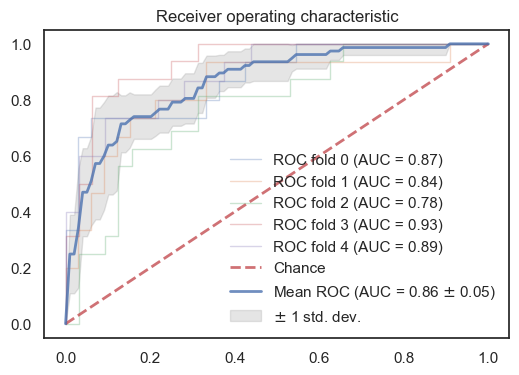

In [38]:
classifier = LogisticRegression(max_iter=1000)
plot_roc(X_train_std, y_train, classifier, 5)

We get better results with cross-validation. And the results variation is close to 1 standard deviation, which indicate the robustnesss of the model

# LDA

As all methods below uses distance metrics - we will standartize the data

In [39]:
# Quick test on accuracy
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, priors=[0.7,0.3])
lda.fit(X_train_std, y_train)
preds_lda = lda.predict(X_test_std)
probs_lda = lda.predict_proba(X_test_std) #probs in scipen notation
accuracy = accuracy_score(y_test, preds_lda)
print(f"Accuracy LDA: {accuracy:.4f}")

Accuracy LDA: 0.8167


In [40]:
pd.crosstab(y_test, preds_lda, colnames=['Prediction'])

Prediction,0,1
DEATH_EVENT,,
0,38,3
1,8,11


In [41]:
#quality evaluating

print(classification_report(y_test, preds_lda))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.79      0.58      0.67        19

    accuracy                           0.82        60
   macro avg       0.81      0.75      0.77        60
weighted avg       0.81      0.82      0.81        60



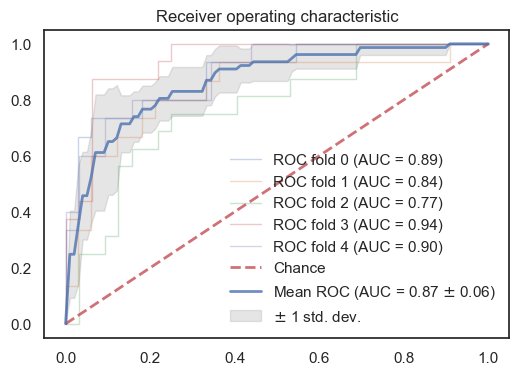

In [42]:
#cross-validation
classifier = LinearDiscriminantAnalysis(solver="svd", store_covariance=True, priors=[0.7,0.3])
plot_roc(X_train_std, y_train, classifier, 5)

With LDA we got a slightly worse results with higher standard deviation. With the same AUC and recall values, LDA has lower f1 score - Logistic regression is better than LDA in this case

# QDA

In [43]:
#import libraries and check priors QDA

qda = QuadraticDiscriminantAnalysis(priors=(0.7,0.3))
qda.fit(X_train_std, y_train)
preds_qda = qda.predict(X_test_std)
probs_qda = qda.predict_proba(X_test_std) #probs in scipen notation

accuracy = accuracy_score(y_test, preds_qda)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7000


In [44]:
pd.crosstab(y_test, preds_qda, colnames=['Prediction'])

Prediction,0,1
DEATH_EVENT,,
0,37,4
1,14,5


In [45]:
#quality evaluating

print(classification_report(y_test, preds_qda))

              precision    recall  f1-score   support

           0       0.73      0.90      0.80        41
           1       0.56      0.26      0.36        19

    accuracy                           0.70        60
   macro avg       0.64      0.58      0.58        60
weighted avg       0.67      0.70      0.66        60



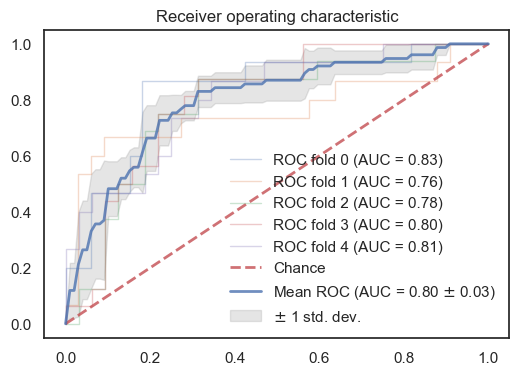

In [46]:
classifier = QuadraticDiscriminantAnalysis(priors=(0.7,0.3))
plot_roc(X_train_std, y_train, classifier, 5)

QDA shows worse performance, with lower AUC, recall and f1-scores.

# KNN

In [47]:
#KNN hyperparameter tunning

param_grid = {'n_neighbors': np.arange(2,11)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = skf)
knn_cv.fit(X_train_std, y_train)
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 5} 0.7822695035460993


In [48]:
knn_pred = knn_cv.predict(X_test_std)
accuracy = accuracy_score(y_test, knn_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7167


In [49]:
pd.crosstab(y_test, knn_pred, colnames=['Prediction'])

Prediction,0,1
DEATH_EVENT,,
0,37,4
1,13,6


In [50]:
#quality evaluating

print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81        41
           1       0.60      0.32      0.41        19

    accuracy                           0.72        60
   macro avg       0.67      0.61      0.61        60
weighted avg       0.70      0.72      0.69        60



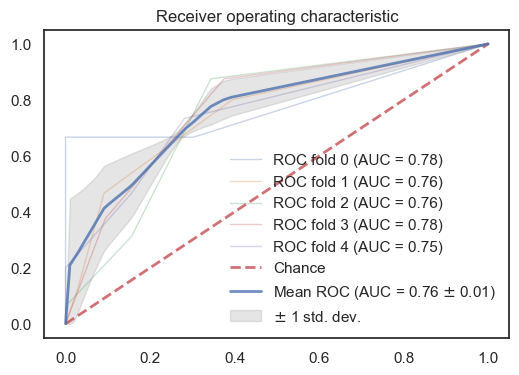

In [51]:
classifier =KNeighborsClassifier(n_neighbors = 3)
plot_roc(X_train_std, y_train, classifier, 5)

KNN shows worse performance, with lower AUC, recall and f1-scores.

# SVM

In [52]:
np.arange(0,1000,0.001)

array([0.00000e+00, 1.00000e-03, 2.00000e-03, ..., 9.99997e+02,
       9.99998e+02, 9.99999e+02])

In [53]:
#KNN hyperparameter tunning

param_grid = {
    'C': np.logspace(-3, 3, 7),  # values like [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'degree': [2, 3, 4, 5],  # Only used when kernel is 'poly'
    'shrinking': [True, False]
}

svm = SVC()
svm_cv = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=100,
                                   cv=skf, verbose=2, random_state=42, n_jobs=-1)
svm_cv.fit(X_train_std, y_train)
print(svm_cv.best_params_, svm_cv.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'shrinking': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 1.0} 0.8285460992907803


In [54]:
svm_pred = svm_cv.predict(X_test_std)
accuracy = accuracy_score(y_test, svm_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7667


In [55]:
pd.crosstab(y_test, svm_pred, colnames=['Prediction'])

Prediction,0,1
DEATH_EVENT,,
0,37,4
1,10,9


In [56]:
#quality evaluating

print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        41
           1       0.69      0.47      0.56        19

    accuracy                           0.77        60
   macro avg       0.74      0.69      0.70        60
weighted avg       0.76      0.77      0.75        60



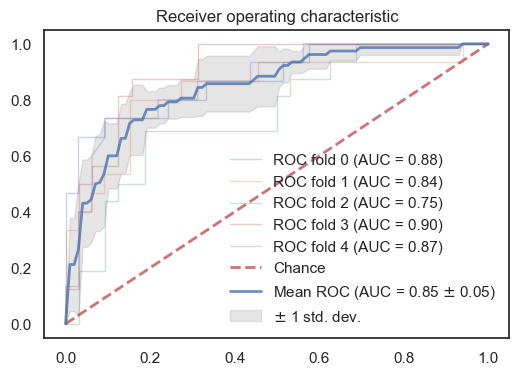

In [57]:
classifier = SVC(shrinking = False, kernel = 'linear', gamma = 0.01, degree = 3, C = 1.0, probability=True)
plot_roc(X_train_std, y_train, classifier, 5)

# Logistic regression with hyperparameters tunning

In [58]:
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],  # 'saga' supports all penalties including 'elasticnet' and 'none'
    'C': np.logspace(-3, 3, 7),
    'l1_ratio': np.linspace(0, 1, 10)  # Only used if penalty is 'elasticnet'
}

# Create a Logistic Regression model
log_reg = LogisticRegression()

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, n_iter=100,
                                   cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train_std, y_train)

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.1111111111111111, 'C': 0.1}
Best Score:  0.8534574468085105


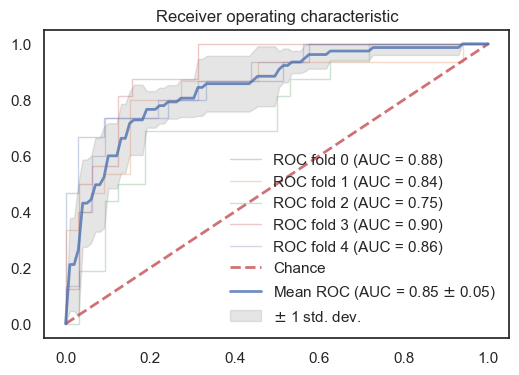

In [59]:
log = LogisticRegression(solver = 'saga', penalty = 'elasticnet',  l1_ratio = 0.88, C = 0.1)
plot_roc(X_train_std, y_train, classifier, 5)

In [60]:
log.fit(X_train_std, y_train)
logreg_pred = log.predict(X_test_std)
print(classification_report(y_test,logreg_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87        41
           1       0.82      0.47      0.60        19

    accuracy                           0.80        60
   macro avg       0.81      0.71      0.73        60
weighted avg       0.80      0.80      0.78        60



In [61]:
pd.crosstab(y_test, y_pred, colnames=['Prediction'])

Prediction,0,1
DEATH_EVENT,,
0,32,9
1,14,5


This is a good example of overcomplicated model: after tunning model's performance has decreased in comparison to simple LogisticRegression().

# Summary

In [62]:
predictions = {
    'LogReg': pred,
    'LDA': preds_lda,
    'QDA': preds_qda,
    'KNN': knn_pred,
    'SVM': svm_pred
}

metrics_data = {}

# Loop through predictions dictionary
for model_name, pred in predictions.items():
    report_dict = classification_report(y_test, pred, output_dict=True)
    
    # Extract recall for class '1' and accuracy
    metrics = {
        'recall_class_1': report_dict['1']['recall'],
        'accuracy': report_dict['accuracy']
    }
    
    metrics_data[model_name] = metrics

# Create a DataFrame for easy comparison and transpose it
df = pd.DataFrame(metrics_data).T
print(df)

        recall_class_1  accuracy
LogReg        0.578947  0.816667
LDA           0.578947  0.816667
QDA           0.263158  0.700000
KNN           0.315789  0.716667
SVM           0.473684  0.766667


We inspected 6 classification algorythms. From all optiona SVM showed the best performance due to higher recall with equal AUC. The resulst are strong and consistent due to using stratified cross validation procedure. Final model has 0.80 accuracy for test set, while 0.87 accuracy during cross-validation and std = 0.03, which can indicate overfitting problem. Such situation can further be fixed by hyperparamters tunning. Alternatively, test set size may be to small, and we should collect more data.

<Axes: >

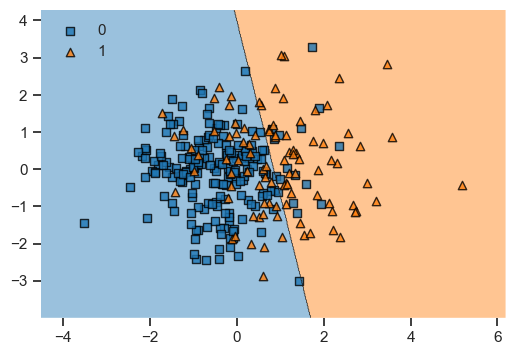

In [63]:
# Plotting decision regions
svm = SVC(shrinking = False, kernel = 'linear', gamma = 0.01, degree = 3, C = 1.0, probability=True)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full_std)
svm.fit(X_pca, y_full.values)
plot_decision_regions(X_pca, y_full.values, clf=svm, legend=2)

The following plot can be used for  decision boudary visualisation of selected model